In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lstsq

In [152]:
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from scipy.stats import norm
from sklearn.cluster import OPTICS

# Generate Dataset

In [402]:
np.random.seed(seed=13)  # set seed so the dataset is the same whenever this NB is ran

dataset_size = 3000
num_modes = 3
noise = 0.005

x = np.random.uniform(-1,1, dataset_size)
x_mode = np.random.choice(num_modes, dataset_size)

a = np.random.uniform(-1,1,num_modes)
b = np.random.uniform(-0,0,num_modes)

y = np.empty(x.shape)
# get modes
for i in range(num_modes):
    y[x_mode == i] = x[x_mode == i] * a[i] + b[i] + np.random.normal(scale=noise, size=x[x_mode == i].shape)
    

# add some outlier points
y_tmp = np.random.uniform(y.min(), y.max(), size=int(0.1 * dataset_size))
x_tmp = np.random.uniform(-1,1, int(0.1 * dataset_size))
x_mode_tmp = np.ones(300) * num_modes

x = np.concatenate((x, x_tmp))
y = np.concatenate((y, y_tmp))
x_mode = np.concatenate((x_mode, x_mode_tmp))

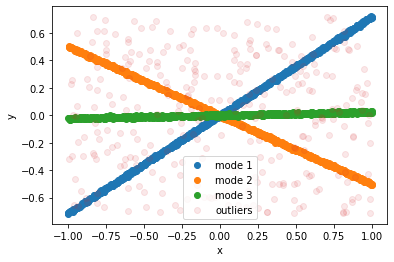

In [403]:
for i in range(num_modes):
    plt.scatter(x[x_mode == i], y[x_mode == i], label=f'mode {i+1}')
    
plt.scatter(x[x_mode == num_modes], y[x_mode == num_modes], alpha=0.1, label=f'outliers')
plt.legend()
plt.ylabel('y')
plt.xlabel('x')
plt.show()

In [404]:
dataset = np.stack([x,y], axis=-1)
dataset.shape

(3300, 2)

# Get Inliers with RANSAC

### ransac function

**Idea to return N hypothesis** - the problem with it may be that top N hypothesis may refer to the very same hypothesis. It may be important to keep N high or to combine similar hypothesis together (thus reduce number of hypothesis, clustering?), before choosing the N best hypothesis

In [405]:
def ransac(data,model, n, iterations, t, d, num_best_hypothesis=1, return_all=False):
    """
    data - a set of observed data points
    model - a model that can be fitted to data points
    n - the minimum number of data values required to fit the model
    iterations - the number of iterations to perform for ransac
    t - a threshold value for determining when a data point fits a model
    d - the number of close data values required to assert that a model fits well to data
    num_best_hypothesis - the number of best hypothesis that RANSAC should store and output.
    Return:
        bestfit - model parameters which best fit the data (or nil if no good model is found)
    """

    bestfit = None
    besterr = np.inf
    best_inlier_idxs = None
    set_of_hypothesis = np.empty((iterations, 2))
    score_of_hypothesis = np.empty((iterations))

    
    # compute 'iterations' number of models
    for i in range(iterations):
        maybe_idxs, test_idxs = random_partition(n,data.shape[0])
        maybeinliers = data[maybe_idxs,:]
        test_points = data[test_idxs]
        maybemodel = model.fit(maybeinliers)
        
        test_err = model.get_error(test_points, maybemodel)  # this gets error per point
        also_idxs = test_idxs[test_err < t]  # here we select indexes of other point which lie within the threshold. 
        
        inlier_score = float(len(also_idxs) + n) / data.shape[0]
        set_of_hypothesis[i] = np.reshape(maybemodel, 2)
        score_of_hypothesis[i] = inlier_score

        
    # sort all model hypothesis by their inlier score
    sorted_indexes = np.argsort(score_of_hypothesis)[::-1]
    sorted_hypothesis = set_of_hypothesis[sorted_indexes]
    sorted_hyp_scores = score_of_hypothesis[sorted_indexes]
    # take 5% best poses from K itterations
    frac_of_K = 0.05
    best_sorted_hypothesis = sorted_hypothesis[:int(frac_of_K * iterations)]
    
    plt.hist(sorted_hypothesis[:,0], density=True, bins=int(30/frac_of_K), alpha=0.2)
#     plt.hist(sorted_hypothesis[:,0], density=True, weights=sorted_hyp_scores, bins=int(30/frac_of_K), alpha=0.1)
    plt.hist(best_sorted_hypothesis[:,0], density=True, bins=30)
    plt.show()
    
    
    # get BEst hypothesis - note: the number of est hypothesisdepends on the solution of the clustering method
    # each cluster should have number of elements a minimum of 0.5% 
    best_pose_clustering = OPTICS(min_samples= int(frac_of_K * 0.05 * iterations)).fit(np.expand_dims(best_sorted_hypothesis[:,0], axis=-1))
    clustering_assignments = best_pose_clustering.labels_

    num_best_hypothesis = len(np.unique(clustering_assignments))
    best_hypothesis = [None] * num_best_hypothesis
    print(num_best_hypothesis)
    for i, clust in enumerate(np.unique(clustering_assignments)):
        hypothesis = best_sorted_hypothesis[clustering_assignments == clust]
        best_hypothesis[i] = np.mean(hypothesis, axis=0)

    
    # for 'num_best_hypothesis' best models, get imporved model - based on all inlier points - and get indeces of inliers
    best_models = [None] * num_best_hypothesis
    models_inlier_indexes = [None] * num_best_hypothesis
    for i in range(num_best_hypothesis):
        # get inlier data points
        test_err = model.get_error(data, np.reshape(best_hypothesis[i], (2,1)))
        inlier_indexes = test_err < t
        models_inlier_indexes[i] = inlier_indexes
        
        # get model
        best_models[i] = model.fit(data[inlier_indexes])
        
    return num_best_hypothesis, best_models, models_inlier_indexes, best_sorted_hypothesis


def random_partition(n,n_data):
    """return n random rows of data (and also the other len(data)-n rows)"""
    all_idxs = np.arange( n_data )
    np.random.shuffle(all_idxs)
    idxs1 = all_idxs[:n]
    idxs2 = all_idxs[n:]
    return idxs1, idxs2

### linear model for RANSAC to find best fitting linear model

In [406]:
class LinearLeastSquaresModel:
    """linear system solved using linear least squares

    This class serves as an example that fulfills the model interface
    needed by the ransac() function.
    
    """
    def __init__(self,input_columns,output_columns,debug=False):
        self.input_columns = input_columns
        self.output_columns = output_columns
        self.debug = debug
    def fit(self, data):
        A = np.vstack([data[:,i] for i in self.input_columns]).T
        A = np.concatenate([A,np.ones(A.shape)], axis=-1) # add 1s for intercept

        B = np.vstack([data[:,i] for i in self.output_columns]).T
        x,resids,rank,s = lstsq(A,B)  # scipy.linalg.lstsq
        return x
    
    def get_error( self, data, model):
        A = np.vstack([data[:,i] for i in self.input_columns]).T
        A = np.concatenate([A,np.ones(A.shape)], axis=-1) # add 1s for intercept
        
        B = np.vstack([data[:,i] for i in self.output_columns]).T
        B_fit = np.dot(A,model)
        err_per_point = np.sum((B-B_fit)**2,axis=1) # sum squared error per row
        return err_per_point

### run ransac

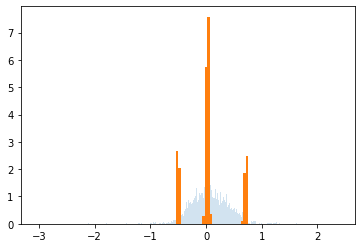

8


In [420]:
# ransac:
# INPUT: entire dataset
# OUTPUT: set of M points which are considered inliers

data = dataset
model = LinearLeastSquaresModel([0],[1])
n = 5  # this needs to be low if we want to capture all true poses
k = 5000
t = 0.001
d = 100

N = 2
N, model_parameters, inlier_indexes, five_percentile_best_poses = ransac(data,model,n,k,t,d,num_best_hypothesis=N, return_all=True)

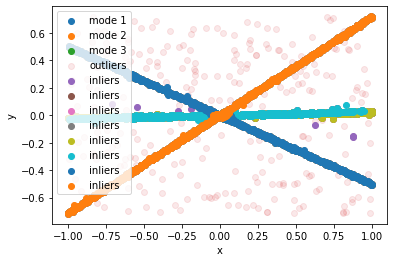

In [421]:
for i in range(num_modes):
    plt.scatter(x[x_mode == i], y[x_mode == i], label=f'mode {i+1}')
plt.scatter(x[x_mode == num_modes], y[x_mode == num_modes], alpha=0.1, label=f'outliers')
for i in range(N):
    plt.scatter(x[inlier_indexes[i]], y[inlier_indexes[i]], label='inliers')
plt.legend()
plt.ylabel('y')
plt.xlabel('x')
plt.show()

## Plot inliers (just for visualisation)

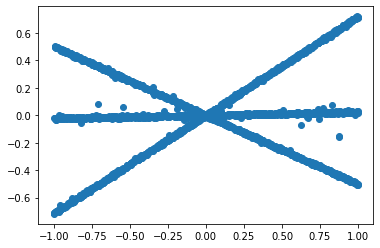

In [442]:
for i in range(len(model_parameters)):
    if i == 0:
        all_inliers = inlier_indexes[i]
    else:
        all_inliers += inlier_indexes[i]
all_inliers = all_inliers.astype(bool)
plt.scatter(x[all_inliers], y[all_inliers])
plt.show()

# Fit Pose Distribution to data

In [422]:
model_parameters

[array([[-0.10620414],
        [ 0.0004382 ]]),
 array([[ 0.0225383 ],
        [-0.00035719]]),
 array([[0.02295052],
        [0.00018494]]),
 array([[2.31855819e-02],
        [5.92849696e-05]]),
 array([[ 0.02246907],
        [-0.00035374]]),
 array([[0.02549947],
        [0.00051985]]),
 array([[-5.02315649e-01],
        [ 2.94950751e-04]]),
 array([[7.17522398e-01],
        [7.87903816e-05]])]

In [423]:
# a_pose = (y[inlier_indexes[i]] - b_true) / x[inlier_indexes[i]] 
# ^ this pose computation method is quite prone to producing outliers.

# get pose estimates for all the inlier samples
a_pose = []
for i in range(len(model_parameters)):
    a_true = model_parameters[i][0][0]
    b_true = model_parameters[i][1][0] 
    
    if len(a_pose) == 0:
        a_pose = (y[inlier_indexes[i]] - b_true) / x[inlier_indexes[i]]
        a_pose = np.expand_dims(a_pose, axis=-1)

    else:
        a_pose_tmp = (y[inlier_indexes[i]] - b_true) / x[inlier_indexes[i]]
        a_pose_tmp = np.expand_dims(a_pose_tmp, axis=-1)
        a_pose = np.concatenate((a_pose, a_pose_tmp), axis=0)


In [424]:
# a_pose = five_percentile_best_poses[:,:1]

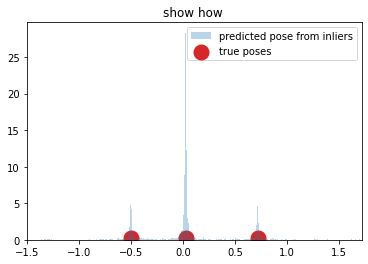

In [434]:
plt.hist(a_pose, bins=300, density=True, alpha=0.3, label='predicted pose from inliers')
plt.scatter(a,[0.2]*num_modes,linewidth=10, color='tab:red', label='true poses')
plt.legend()
plt.xlim(a.min()-1,a.max()+1)
plt.title('show how ')
plt.show()

In [429]:
# K = num_modes  # number of mixtures

# # initialise mixing components
# mixing_components = np.random.normal(size=K)
# mixing_components = np.exp(mixing_components) / np.sum(np.exp(mixing_components)) # normalise mixing components
# means = np.random.normal(size=K)
# sigmas = np.random.normal(size=K)

**To avoid singularity colapse problem when fitting Expectation-Maximisation GMM** we use Variational GMM which uses prior thus will avoid this problem. However it has an extra hyper parameter and may take slightly more time. https://scikit-learn.org/stable/modules/mixture.html

191.26348430290034
0.1390802432988816 [-0.49946504] [0.00200641]
232.12639635778567
0.13255395907570533 [0.71673483] [0.00170288]
4.746646134259103
0.07468024237367558 [-0.10999966] [0.08404562]
0.7035909710625122
0.05430784309817355 [0.1434707] [0.56700875]
527.5423062259397
0.5884667325018365 [0.02279492] [0.00035975]
0.011033873291752538
0.010910979651727474 [1.05641245] [36.15614117]


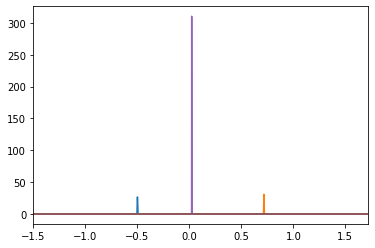

In [432]:
np.random.seed(12)

gmm = BayesianGaussianMixture(n_components=num_modes+3, 
                              covariance_type='diag', 
                              max_iter=1000, 
                              weight_concentration_prior=1
                             ).fit(a_pose)

n_points = np.arange(a.min()-1, a.max()+1, (a.max() - a.min()) / 1000)
# plt.figure()
# plt.hist(dataset, bins=50, histtype='stepfilled', density=True, alpha=0.5)
# # plt.xlim(0, 360)
# f_axis = dataset.copy().ravel()
# f_axis.sort()
# a = []
for weight, mean, var in zip(gmm.weights_, gmm.means_, gmm.covariances_):
    print(norm.pdf(n_points, loc=mean[0], scale=var[0]).max())
    plt.plot(n_points, weight * norm.pdf(n_points, loc=mean[0], scale=var[0]))
    print(weight, mean, var)
plt.xlim(a.min()-1, a.max()+1)
#     a.append(weight*norm.pdf(f_axis, mean, np.sqrt(covar)).ravel())
#     plt.plot(f_axis, a[-1])
# plt.plot(f_axis, np.array(a).sum(axis =0), 'k-')
# plt.xlabel('Variable')
# plt.ylabel('PDF')
# plt.tight_layout()
plt.show()

In [433]:
mixing_components = np.random.normal(size=5)
mixing_components

array([ 0.21306676,  0.08580092,  2.2457508 , -1.56314375,  0.72597452])